In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import act_max_util as amu

from autoencoder import Autoencoder
from solver import *

%load_ext autoreload
%autoreload 2

### Load data

In [2]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

### Activation Maximization

In [3]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

### Load Model

In [4]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32]

In [5]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

### RFA

In [6]:
modelpath = f'/home/david/sparsify_models/good_models/01'
epoch = 49

data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

sae = load_model(modelpath, 'SAE', epoch)
dae = load_model(modelpath, 'DAE', epoch)

layer_name = 'bottle_neck'
sae_activation_dictionary = {}
dae_activation_dictionary = {}

sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))
dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

sae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=sae,
                    input=input,
                    layer_activation=sae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    sae_rf_ls.append(output.detach().numpy())

dae_rf_ls = []
for i in range(size_ls[epoch]):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=dae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

/tmp/ipykernel_17705/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

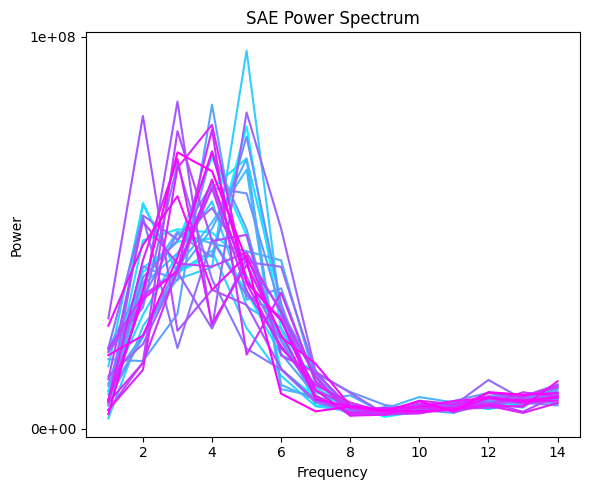

In [47]:
import matplotlib.pyplot as pl
import numpy as np
import scipy.stats as stats

colors = pl.cm.cool(np.linspace(0, 1, len(sae_rf_ls)))
pl.figure(figsize=(6, 5))

for idx, image_data in enumerate(sae_rf_ls):
    image = image_data.reshape(28, 28)
    npix = image.shape[0]

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic="mean",
                                         bins=kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    pl.plot(kvals, Abins, color=colors[idx], label=f"RF{idx+1}")

pl.xlabel('Frequency')
pl.ylabel('Power')
pl.title('SAE Power Spectrum')
yticks = [0, 1e8]
pl.yticks(yticks, [f'{ytick:.0e}' for ytick in yticks])
pl.tight_layout()
pl.show()

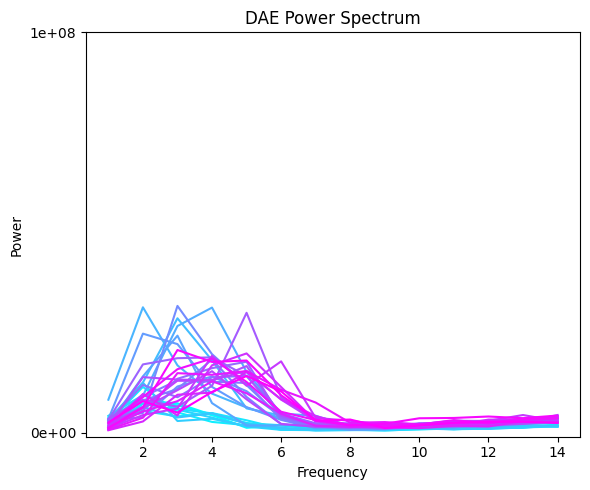

In [48]:
import matplotlib.pyplot as pl
import numpy as np
import scipy.stats as stats

colors = pl.cm.cool(np.linspace(0, 1, len(dae_rf_ls)))
pl.figure(figsize=(6, 5))

for idx, image_data in enumerate(dae_rf_ls):
    image = image_data.reshape(28, 28)
    npix = image.shape[0]

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic="mean",
                                         bins=kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    pl.plot(kvals, Abins, color=colors[idx], label=f"RF{idx+1}")

pl.xlabel('Frequency')
pl.ylabel('Power')
pl.title('DAE Power Spectrum')
yticks = [0, 1e8]
pl.yticks(yticks, [f'{ytick:.0e}' for ytick in yticks])
pl.tight_layout()
pl.show()

In [265]:
def z_score(image):
    """
    Normalize an image using the z-score normalization.
    Normalized image: (pixel - mean) / std
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

def radial_profile(data, center=None):
    """
    Compute the radial profile of a 2D array data.
    """
    y, x = np.indices((data.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    # r = r.astype(int)

    # tbin = np.bincount(r.ravel(), data.ravel())
    # nr = np.bincount(r.ravel())

    r_flat = r.ravel()
    data_flat = data.ravel()

    # Get the unique radial distances and indices of the first occurrence
    unique_r, inverse_indices = np.unique(r_flat, return_inverse=True)
    
    # Sum the data values for each unique radial distance
    summed_data = np.zeros_like(unique_r)
    counts = np.zeros_like(unique_r)
    
    np.add.at(summed_data, inverse_indices, data_flat)
    np.add.at(counts, inverse_indices, 1)

    print(counts)
    
    # Compute the average value for each unique radius
    radial_profile = summed_data / counts

    # radialprofile = tbin / nr
    return unique_r, radial_profile

def power_spectrum_radial_average(image):
    """
    Calculate the radial average of the power spectrum for a 2D grey-scale image.
    :param image: 2D numpy array representing the image
    :return: radial average of the power spectrum
    """
    # Take the 2D Fourier transform of the image and shift the zero frequency component to the center
    f_transform = np.fft.fftshift(np.fft.fft2(image))

    # Compute the power spectrum (magnitude squared of the Fourier coefficients)
    power_spectrum = np.abs(f_transform) ** 2

    # Compute the radial profile of the power spectrum
    unique_r, radial_avg = radial_profile(power_spectrum)

    return unique_r, radial_avg

print(power_spectrum_radial_average(z_score(sae_rf_ls[0]).reshape(28, 28)))


[ 4.  8.  4.  8.  8. 12.  8.  8.  8.  8.  4.  8.  8. 16.  8.  4. 16.  8.
  8.  8.  8.  8.  8.  4. 16.  8. 16.  8.  8.  8. 12.  8.  8. 16.  8.  8.
 16. 16. 12.  8.  8.  8.  8.  8.  8. 16.  8.  8.  8. 12.  8. 16.  8.  8.
 24.  8.  8.  8.  8.  4. 16.  8.  8. 16.  8.  8.  8.  8.  8. 16.  4.  8.
  8.  8.  8.  8.  8.  8.  4.  8.  8.  8.  8.  4.  8.  8.  4.]
(array([ 0.70710678,  1.58113883,  2.12132034,  2.54950976,  2.91547595,
        3.53553391,  3.80788655,  4.30116263,  4.52769257,  4.74341649,
        4.94974747,  5.14781507,  5.52268051,  5.70087713,  6.04152299,
        6.36396103,  6.51920241,  6.67083203,  6.96419414,  7.1063352 ,
        7.38241153,  7.51664819,  7.64852927,  7.77817459,  7.90569415,
        8.27647268,  8.51469318,  8.63133825,  8.74642784,  8.86002257,
        9.19238816,  9.30053762,  9.5131488 ,  9.61769203,  9.82344135,
        9.92471662, 10.12422837, 10.51189802, 10.60660172, 10.70046728,
       10.79351657, 10.9772492 , 11.06797181, 11.33578405, 11.4236596

In [249]:
srf_freq_ls[0]

array([1080.5       , 5956.875     , 6235.7       , 3813.8       ,
       3946.75      , 3138.4375    ,  802.97727273,  291.26923077,
        165.04166667,  135.68333333,  149.27941176,  158.25      ,
        177.93478261,  181.30263158,  179.25      ,  200.85      ,
        162.78571429,  202.05      ,  304.5       ,  528.25      ])

In [268]:
srf_freq_ls[0]

(array([ 0.70710678,  1.58113883,  2.12132034,  2.54950976,  2.91547595,
         3.53553391,  3.80788655,  4.30116263,  4.52769257,  4.74341649,
         4.94974747,  5.14781507,  5.52268051,  5.70087713,  6.04152299,
         6.36396103,  6.51920241,  6.67083203,  6.96419414,  7.1063352 ,
         7.38241153,  7.51664819,  7.64852927,  7.77817459,  7.90569415,
         8.27647268,  8.51469318,  8.63133825,  8.74642784,  8.86002257,
         9.19238816,  9.30053762,  9.5131488 ,  9.61769203,  9.82344135,
         9.92471662, 10.12422837, 10.51189802, 10.60660172, 10.70046728,
        10.79351657, 10.9772492 , 11.06797181, 11.33578405, 11.42365966,
        11.51086443, 11.5974135 , 11.7686023 , 11.85326959, 12.02081528,
        12.10371844, 12.34908904, 12.509996  , 12.58967831, 12.74754878,
        12.9034879 , 12.98075499, 13.20984481, 13.28533026, 13.43502884,
        13.50925609, 13.58307771, 13.65650028, 13.72953022, 13.94632568,
        14.0890028 , 14.15980226, 14.23024947, 14.3

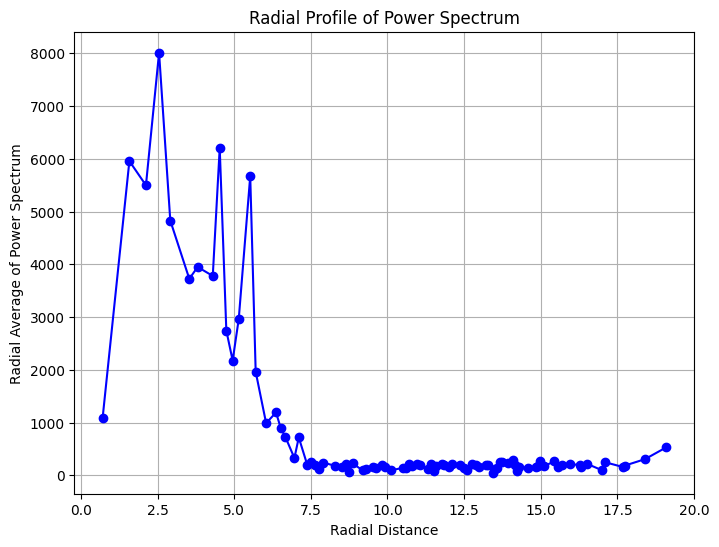

In [273]:
radial_distances, radial_avg = srf_freq_ls[0]

plt.figure(figsize=(8, 6))
plt.plot(radial_distances, radial_avg, marker='o', linestyle='-', color='b')

# Labeling the axes
plt.xlabel('Radial Distance')
plt.ylabel('Radial Average of Power Spectrum')

# Adding a title
plt.title('Radial Profile of Power Spectrum')

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


[ 4.  8.  4.  8.  8. 12.  8.  8.  8.  8.  4.  8.  8. 16.  8.  4. 16.  8.
  8.  8.  8.  8.  8.  4. 16.  8. 16.  8.  8.  8. 12.  8.  8. 16.  8.  8.
 16. 16. 12.  8.  8.  8.  8.  8.  8. 16.  8.  8.  8. 12.  8. 16.  8.  8.
 24.  8.  8.  8.  8.  4. 16.  8.  8. 16.  8.  8.  8.  8.  8. 16.  4.  8.
  8.  8.  8.  8.  8.  8.  4.  8.  8.  8.  8.  4.  8.  8.  4.]
[ 4.  8.  4.  8.  8. 12.  8.  8.  8.  8.  4.  8.  8. 16.  8.  4. 16.  8.
  8.  8.  8.  8.  8.  4. 16.  8. 16.  8.  8.  8. 12.  8.  8. 16.  8.  8.
 16. 16. 12.  8.  8.  8.  8.  8.  8. 16.  8.  8.  8. 12.  8. 16.  8.  8.
 24.  8.  8.  8.  8.  4. 16.  8.  8. 16.  8.  8.  8.  8.  8. 16.  4.  8.
  8.  8.  8.  8.  8.  8.  4.  8.  8.  8.  8.  4.  8.  8.  4.]
[ 4.  8.  4.  8.  8. 12.  8.  8.  8.  8.  4.  8.  8. 16.  8.  4. 16.  8.
  8.  8.  8.  8.  8.  4. 16.  8. 16.  8.  8.  8. 12.  8.  8. 16.  8.  8.
 16. 16. 12.  8.  8.  8.  8.  8.  8. 16.  8.  8.  8. 12.  8. 16.  8.  8.
 24.  8.  8.  8.  8.  4. 16.  8.  8. 16.  8.  8.  8.  8.  8. 16.  4.  8.


[]

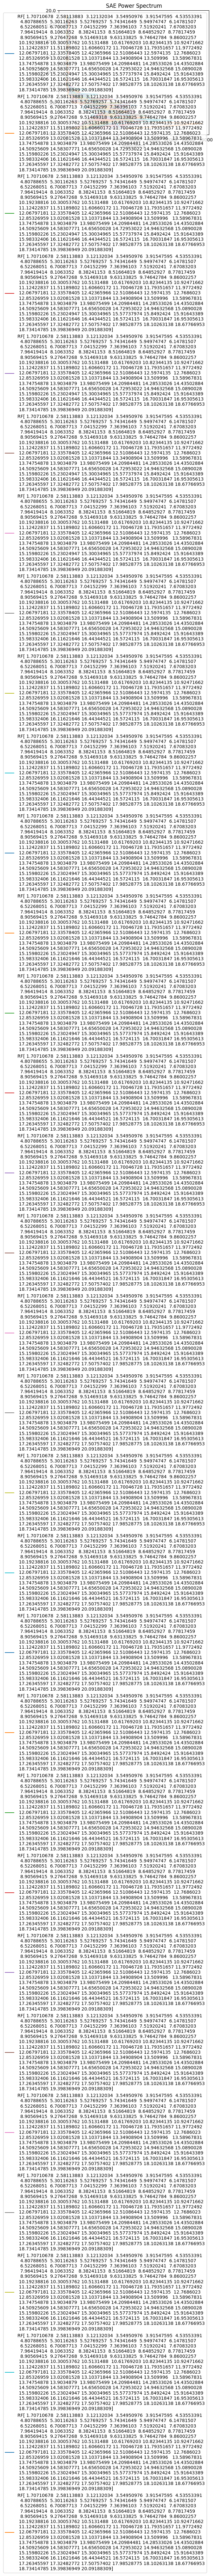

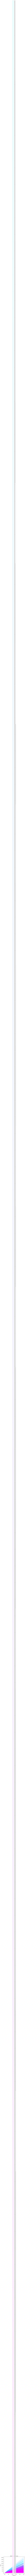

In [269]:
srf_freq_ls = []
for srf in sae_rf_ls:
    radial_avg = power_spectrum_radial_average(z_score(srf.reshape(28, 28)))
    srf_freq_ls.append(radial_avg)

drf_freq_ls = []
for drf in dae_rf_ls:
    radial_avg = power_spectrum_radial_average(z_score(drf.reshape(28, 28)))
    drf_freq_ls.append(radial_avg)

# plot the radial power spectrum
colors = plt.cm.cool(np.linspace(0,1,32))
plot = plt.figure(figsize=(6,5))
for i,freq in srf_freq_ls:
    plt.plot(freq,i,label= 'RF'+str(i+1))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('SAE Power Spectrum')
plt.legend()
plt.plot()

plot = plt.figure(figsize=(6,5))
for i,freq in enumerate(drf_freq_ls):
    plt.plot(freq,color=colors[i],label= 'RF'+str(i+1))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('DAE Power Spectrum')
plt.legend()
plt.plot()

In [212]:
srf_freq_ls[5]

array([5307.46017456, 7124.49601746, 7784.44688416, 4589.40649109,
       2801.40273176, 1417.3443768 ,  615.9569447 ,  269.74579041,
        179.56698066,  187.12697372,  181.86561151,  162.31030306,
        213.55273737,  183.67283965,  172.21519216,  297.8575547 ,
        344.05027849,  419.42193298,  601.82519913,  340.26145554])

In [208]:
np.argmax(srf_freq_ls[0])

np.int64(2)

In [216]:
mean_power = np.mean(drf_freq_ls[0])
std_power = np.std(drf_freq_ls[0])

mean_power, std_power

(np.float64(1793.5893394204013), np.float64(2999.8477811289863))

In [213]:
mean_power = np.mean(srf_freq_ls[0])
std_power = np.std(srf_freq_ls[0])

significant_frequencies = kvals[srf_freq_ls[0] > mean_power + std_power]

IndexError: boolean index did not match indexed array along axis 0; size of axis is 14 but size of corresponding boolean axis is 20

In [219]:
import numpy as np

def z_score(image):
    """
    Normalize an image using the z-score normalization.
    Normalized image: (pixel - mean) / std
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

def radial_profile(data, center=None):
    """
    Compute the radial profile of a 2D array data without binning.
    """
    y, x = np.indices((data.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    # Calculate the radial distance of each point from the center
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    # Sort the distances and their corresponding data values
    sorted_indices = np.argsort(r.ravel())
    sorted_r = r.ravel()[sorted_indices]
    sorted_data = data.ravel()[sorted_indices]
    
    # Find unique radii and their corresponding indices
    unique_radii, index = np.unique(sorted_r, return_index=True)
    
    # Calculate the mean for each radius
    radial_profile = [sorted_data[index[i]:index[i+1]].mean() if i+1 < len(index) else sorted_data[index[i]:].mean() for i in range(len(index))]
    
    return unique_radii, radial_profile

def power_spectrum_radial_average(image):
    """
    Calculate the radial average of the power spectrum for a 2D grey-scale image.
    :param image: 2D numpy array representing the image
    :return: radial distances and radial average of the power spectrum
    """
    # Take the 2D Fourier transform of the image and shift the zero frequency component to the center
    f_transform = np.fft.fftshift(np.fft.fft2(image))

    # Compute the power spectrum (magnitude squared of the Fourier coefficients)
    power_spectrum = np.abs(f_transform) ** 2

    # Compute the radial profile of the power spectrum
    radial_distances, radial_avg = radial_profile(power_spectrum)

    return radial_distances, radial_avg

# Example usage with an image array
# Replace 'sae_rf_ls[0]' with your actual image array
radial_distances, radial_avg = power_spectrum_radial_average(sae_rf_ls[0].reshape(28, 28))


In [221]:
radial_avg

[np.float32(564162.7),
 np.float32(2983998.8),
 np.float32(2754026.5),
 np.float32(4013099.0),
 np.float32(2418930.0),
 np.float32(1865548.6),
 np.float32(1978160.5),
 np.float32(1892908.0),
 np.float32(3108284.2),
 np.float32(1373984.8),
 np.float32(1089795.4),
 np.float32(1482122.9),
 np.float32(2840787.0),
 np.float32(983160.6),
 np.float32(494424.97),
 np.float32(596550.0),
 np.float32(447631.38),
 np.float32(362591.12),
 np.float32(163107.23),
 np.float32(358934.44),
 np.float32(99174.7),
 np.float32(121691.375),
 np.float32(100123.72),
 np.float32(62817.11),
 np.float32(119235.02),
 np.float32(91419.44),
 np.float32(74916.77),
 np.float32(106961.3),
 np.float32(35272.89),
 np.float32(113960.79),
 np.float32(45191.69),
 np.float32(59045.65),
 np.float32(80036.54),
 np.float32(68228.164),
 np.float32(93924.36),
 np.float32(74620.28),
 np.float32(47909.945),
 np.float32(70582.83),
 np.float32(65837.38),
 np.float32(105401.66),
 np.float32(92252.484),
 np.float32(104398.0),
 np.float